## Simulation of  FHN model with (generalized) phase model

### Setup

In [17]:
using GeneralizedPhaseModel
using DifferentialEquations, PyPlot

Define the vector field of the system.

In [18]:
# Parameters and variables
c = 0.7; d = 0.8; eps = 0.08; # FHN parameters

Nθ = 10000  # The number of splitting phase for one period; (Int)
D = 2        # Dimension of states; (Int)

# FHN vector field
dvdt(X, I) = X[1] - X[1]^3/3.0 - X[2] + I
dudt(X) = eps * (X[1] + c - d * X[2])

F(X, I) = [dvdt(X, I), dudt(X)]

F (generic function with 1 method)

In [19]:
Imin = 0.4; Imax = 1.0; dI = 0.1
dt = 1e-3
D = 2
Nθ = 1000
Irange = Imin:dI:Imax
NI = size(Irange)[1]
alg = Tsit5()
origin_val_idx = 1
origin_thr = 0.0

# input
It(t, α=0.6) = α * (sin(0.02t)^2) + 0.4

trange = 0:dt:200
Nt = size(trange)[1]

200001

In [20]:
Imean = sum(It.(trange)) / Nt

0.6628986103885433

The time variation of the input is shown below.

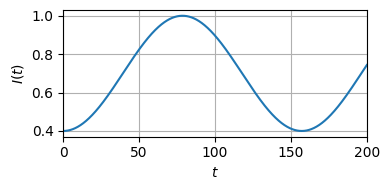

In [21]:
figure(figsize=(4, 2))
plot(trange, It.(trange))
xlim(trange[1], trange[end]); xlabel(L"$t$"); ylabel(L"$I(t)$"); grid();
tight_layout()

Obtain the angular frequency $\omega(I)$, phase sensitivity function $\zeta(\theta, I), \xi(\theta, I)$, and the coordinates of stable periodic solution $X_s(I)$ for various inputs.

In [6]:
ωI, ζθI, ξθI, XsI = generalized_phase_sensitivity_func(F, Imin, Imax, dI, D, Nθ, nothing, dt, alg, origin_val_idx, origin_thr);

LoadError: UndefVarError: alg not defined

Plot the coordinates of the stable periodic solution to check if the simulation was stable.

In [7]:
cmap = get_cmap("viridis")

figure(figsize=(7, 3))
θ = range(0, 2π, length=Nθ) 
subplot(1,2,1)
for i = 1:NI
    I = Irange[i]
    plot(θ, XsI[1](θ, I), color=cmap(i/NI))
end
xlim(0, 2π); xticks([0, 0.5π, π, 1.5π, 2π], ["0", "π/2", "π", "3/2π", "2π"]);
grid(); xlabel(L"$\theta$"); ylabel(L"x(\theta, I)"); 

subplot(1,2,2)
for i = 1:size(Irange)[1]
    I = Irange[i]
    plot(θ, XsI[2](θ, I), color=cmap(i/NI))
end
xlim(0, 2π); xticks([0, 0.5π, π, 1.5π, 2π], ["0", "π/2", "π", "3/2π", "2π"]);
grid(); xlabel(L"$\theta$"); ylabel(L"y(\theta, I)"); 

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=Imin, vmax=Imax))
plt.colorbar(sm, label=L"strength of $I$")

tight_layout()

LoadError: UndefVarError: get_cmap not defined

### Original system
Run a simulation of the original system.

In [8]:
function os_updateX(X, I, t)
    return F(X, I(t))
end

os_updateX (generic function with 1 method)

In [9]:
initX = [1.0, 0.0]

integrator_os = get_ode_integrator(os_updateX, initX, dt, It, alg)
Xos = zeros(Nt, D)

@time for tt in 1:Nt
    Xos[tt, :] = integrator_os.u # memory
    step!(integrator_os, dt, true)
end

LoadError: UndefVarError: It not defined

### Conventional phase model

In [10]:
function conventinal_updateθ!(θ, I, ωI, ζθI, dt)
    θ[1] += (ωI(Imean) + ζθI(θ[1], Imean) * I) * dt
end

conventinal_updateθ! (generic function with 1 method)

In [11]:
Xcpm = zeros(Nt, D)
Θcpm = zeros(Nt)
θcpm = [0.0, ]
@time for tt in 1:Nt
    I = It(trange[tt])
    θcpm = mod.(θcpm, 2π)
    Xcpm[tt, :] = [XsI[i](θcpm[1], I) for i in 1:D] # memory
    Θcpm[tt] = θcpm[1]
    conventinal_updateθ!(θcpm, I, ωI, ζθI, dt)
end

LoadError: UndefVarError: Nt not defined

### Generalized phase model

In [12]:
function generalized_updateθ!(θ, I, ωI, ξθI, dIdt, dt)
    θ[1] += (ωI(I) + ξθI(θ[1], I) * dIdt) * dt
end

generalized_updateθ! (generic function with 1 method)

In [13]:
Xgpm = zeros(Nt, D)
Θgpm = zeros(Nt)
θgpm = [0.0, ]
@time for tt in 1:Nt
    I = It(trange[tt])
    if tt > 1
        dIdt = (I - It(trange[tt-1])) / dt
    else
        dIdt = 0
    end
    θgpm = mod.(θgpm, 2π)
    Xgpm[tt, :] = [XsI[i](θgpm[1], I) for i in 1:D] # memory
    Θgpm[tt] = θgpm[1]
    generalized_updateθ!(θgpm, I, ωI, ξθI, dIdt, dt)
end

LoadError: UndefVarError: Nt not defined

### Results

Plot the phase change.

In [14]:
figure(figsize=(8, 2))
plot(trange, Θgpm, color="tab:red", label="generalized phase model")
plot(trange, Θcpm, color="tab:gray", label="conventional phase model")
xlim(trange[1], trange[end]); xlabel(L"$t$"); ylabel(L"$θ(t)$"); grid(); 
yticks([0, π, 2π], ["0", "π", "2π"]);
legend(loc="upper left", bbox_to_anchor=(1.05, 1))
tight_layout()

LoadError: UndefVarError: figure not defined

Plot the approximate predictions of conventional and generalized phase models for the dynamics of the original system. Below is the difference between the original system dynamics and the phase model predictions.

In [15]:
figure(figsize=(10, 6))
subplot(2,2,1)
plot(trange, Xos[:, 1], "--", label="original system")
plot(trange, Xgpm[:, 1], color="tab:red", label="generalized phase model")
plot(trange, Xcpm[:, 1], color="tab:gray", label="conventional phase model")
xlim(trange[1], trange[end]); xlabel(L"$t$"); ylabel(L"$x(t)$"); grid(); legend(loc="lower left")

subplot(2,2,2)
plot(trange, Xos[:, 2], "--", label="original system")
plot(trange, Xgpm[:, 2], color="tab:red", label="generalized phase model")
plot(trange, Xcpm[:, 2], color="tab:gray", label="conventional phase model")
xlim(trange[1], trange[end]); xlabel(L"$t$"); ylabel(L"$y(t)$"); grid()

subplot(2,2,3)
plot(trange, Xgpm[:, 1]-Xos[:, 1], color="tab:red", label=L"generalized. $-$ original")
plot(trange, Xcpm[:, 1]-Xos[:, 1], color="tab:gray", label=L"conventional. $-$ original")
xlim(trange[1], trange[end]); xlabel(L"$t$"); ylabel(L"$\Delta x(t)$"); grid(); legend(loc="upper left")

subplot(2,2,4)
plot(trange, Xgpm[:, 2]-Xos[:, 2], color="tab:red")
plot(trange, Xcpm[:, 2]-Xos[:, 2], color="tab:gray")
xlim(trange[1], trange[end]); xlabel(L"$t$"); ylabel(L"$\Delta y(t)$"); grid()

tight_layout()

LoadError: UndefVarError: figure not defined